In [4]:
import pandas as pd
import numpy as np
import re
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from pandas.io.json import json_normalize
import requests
from bs4 import BeautifulSoup
import datetime


In [5]:
pitchfork = pd.read_csv('pitchfork.csv')
pitchfork.sort_values('score', ascending = False)

pitchfork['pub_year'] = pd.DatetimeIndex(pitchfork['pub_date']).year
pitchfork.head(40)

,id,artist,content,genre,label,album,score,best_new_music,author,pub_date,year,pub_year
0,22703,massive attack,"“Trip-hop” eventually became a ’90s punchline,...",electronic,virgin,mezzanine,9.3,0,nate patrin,2017-01-08,1998,2017
1,22721,krallice,"Eight years, five albums, and two EPs in, the ...",metal,hathenter,prelapsarian,7.9,0,zoe camp,2017-01-07,2016,2017
2,22659,uranium club,Minneapolis’ Uranium Club seem to revel in bei...,rock,static shock,all of them naturals,7.3,0,david glickman,2017-01-07,2016,2017
3,22659,uranium club,Minneapolis’ Uranium Club seem to revel in bei...,rock,fashionable idiots,all of them naturals,7.3,0,david glickman,2017-01-07,2016,2017
4,22661,kleenex,Kleenex began with a crash. It transpired one ...,rock,kill rock stars,first songs,9.0,1,jenn pelly,2017-01-06,2016,2017
5,22661,kleenex,Kleenex began with a crash. It transpired one ...,rock,mississippi,first songs,9.0,1,jenn pelly,2017-01-06,2016,2017
6,22661,liliput,Kleenex began with a crash. It transpired one ...,rock,kill rock stars,first songs,9.0,1,jenn pelly,2017-01-06,2016,2017
7,22661,liliput,Kleenex began with a crash. It transpired one ...,rock,mississippi,first songs,9.0,1,jenn pelly,2017-01-06,2016,2017
8,22725,taso,It is impossible to consider a given release b...,electronic,teklife,new start,8.1,0,kevin lozano,2017-01-06,2016,2017
9,22704,little simz,"Rapper Simbi Ajikawo, who records as Little Si...",rap,age 101,stillness in wonderland,7.1,0,katherine st. asaph,2017-01-05,2016,2017


In [6]:
genre_best_new = pitchfork[["genre","score","best_new_music","pub_year"]]
genre_best_new.head()

,genre,score,best_new_music,pub_year
0,electronic,9.3,0,2017
1,metal,7.9,0,2017
2,rock,7.3,0,2017
3,rock,7.3,0,2017
4,rock,9.0,1,2017


In [7]:
# There are no missing values in the dataset that is going to be used.
null_pitchfork = pitchfork.isnull().sum()

print(null_pitchfork)

id                 0
artist             0
content           14
genre              0
label             56
album              3
score              0
best_new_music     0
author             0
pub_date           0
year               0
pub_year           0
dtype: int64


In [8]:
# Get the amount of items per genre
genres_1 = genre_best_new.groupby(["genre"]).size().reset_index()
genres_1

,genre,0
0,electronic,4350
1,experimental,2189
2,folk/country,785
3,global,336
4,jazz,536
5,metal,1027
6,pop/r&b,1676
7,rap,1964
8,rock,10849


In [9]:
# Amount of times appearing in best_new_music
genres_best = genre_best_new.groupby(["genre"])["best_new_music"].sum().reset_index()
genres_best

,genre,best_new_music
0,electronic,244
1,experimental,166
2,folk/country,31
3,global,13
4,jazz,25
5,metal,31
6,pop/r&b,128
7,rap,117
8,rock,748


In [46]:
# Items per genre and best_new_music
genre_best_amount = pd.merge(genres_1, genres_best, on='genre')
genre_best_amount.columns = ['genre', 'total_reviews', 'total_best_new_music']

genre_best_amount.head(20)

,genre,total_reviews,total_best_new_music
0,electronic,4350,244
1,experimental,2189,166
2,folk/country,785,31
3,global,336,13
4,jazz,536,25
5,metal,1027,31
6,pop/r&b,1676,128
7,rap,1964,117
8,rock,10849,748


In [47]:
genre_best_amount.dtypes

genre                   object
total_reviews            int64
total_best_new_music     int64
dtype: object

In [48]:
# Adding the percentages as a float number
pd.options.display.float_format = "{:,.2f}".format

genre_best_amount['percentage'] = (genre_best_amount['total_best_new_music']/genre_best_amount['total_reviews'])*100
genre_best_amount

,genre,total_reviews,total_best_new_music,percentage
0,electronic,4350,244,5.61
1,experimental,2189,166,7.58
2,folk/country,785,31,3.95
3,global,336,13,3.87
4,jazz,536,25,4.66
5,metal,1027,31,3.02
6,pop/r&b,1676,128,7.64
7,rap,1964,117,5.96
8,rock,10849,748,6.89


In [49]:
# Sorting the percentage in descending order
genre_best_amount.sort_values('percentage', ascending=False)

,genre,total_reviews,total_best_new_music,percentage
6,pop/r&b,1676,128,7.64
1,experimental,2189,166,7.58
8,rock,10849,748,6.89
7,rap,1964,117,5.96
0,electronic,4350,244,5.61
4,jazz,536,25,4.66
2,folk/country,785,31,3.95
3,global,336,13,3.87
5,metal,1027,31,3.02


In [50]:
# Making genre the index of the table
genre_best_amount= genre_best_amount.set_index("genre")
genre_best_amount

,total_reviews,total_best_new_music,percentage
genre,,,
electronic,4350,244,5.61
experimental,2189,166,7.58
folk/country,785,31,3.95
global,336,13,3.87
jazz,536,25,4.66
metal,1027,31,3.02
pop/r&b,1676,128,7.64
rap,1964,117,5.96
rock,10849,748,6.89


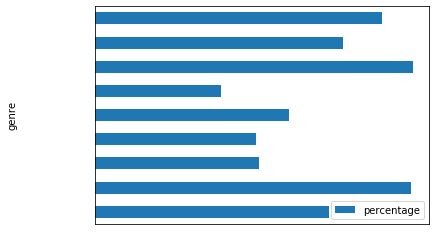

In [56]:
# Making a plot of genre_best_amount
ax = genre_best_amount.plot.barh(y ="percentage")  
ax.tick_params(colors='white')
ax.grid(False)

plt.savefig('percentage_best_new.png', bbox_inches = 'tight', transparent = True)

In [32]:
# Setting the index to genre
genre_best_amount_plot = genre_best_amount.set_index("genre")

genre_best_amount_plot.columns = ['reviews','bestnew']

genre_bestgenre_best_amount_plot.sort_values('reviews', ascending=False)

,reviews,bestnew
genre,,
rock,10849,748
electronic,4350,244
experimental,2189,166
rap,1964,117
pop/r&b,1676,128
metal,1027,31
folk/country,785,31
jazz,536,25
global,336,13


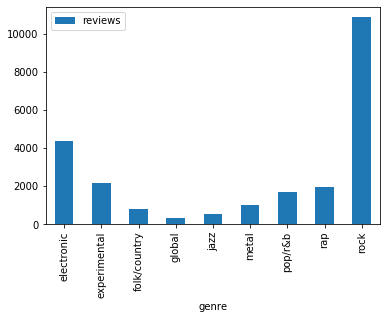

In [34]:
# Plot for reviews
import matplotlib.pyplot as plt 

genre_best_amount_plot.plot.bar(y ="reviews")

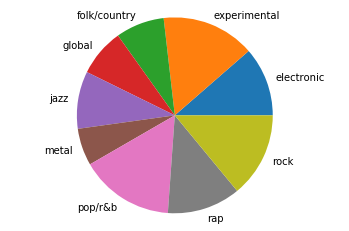

In [69]:
# Pie plot (total is not 100%)

import matplotlib.pyplot as plt
labels = [i for i in genre_best_amount['genre']]
sizes = [i for i in genre_best_amount['percentage']]

plt.pie(sizes, labels = labels) #autopct = '%1.1f%')
plt.axis('equal')
plt.show()

In [59]:
# Music by genre by year with mean score
genre_best_1 = genre_best_new.groupby(["genre","pub_year"])["score"].mean().reset_index()
genre_best_1

,genre,pub_year,score
0,electronic,1999,7.24
1,electronic,2000,7.01
2,electronic,2001,6.82
3,electronic,2002,7.01
4,electronic,2003,6.91
...,...,...,...
162,rock,2013,7.10
163,rock,2014,7.18
164,rock,2015,7.06
165,rock,2016,7.34


In [60]:
# Music by genre by year with mean score: last 10 years
genre_recent = genre_best_1.loc[genre_best_1.pub_year > 2008]
genre_recent

genre_recent.head(10)

,genre,pub_year,score
10,electronic,2009,6.64
11,electronic,2010,6.85
12,electronic,2011,6.89
13,electronic,2012,6.86
14,electronic,2013,7.03
15,electronic,2014,7.04
16,electronic,2015,7.18
17,electronic,2016,7.12
18,electronic,2017,8.00
29,experimental,2009,6.96
